# European Drought Observatory Data


In [16]:
# Magic
%load_ext autoreload
%autoreload 2

# Imports

from tqdm import tqdm
import rasterio
import pandas as pd
import glob
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
import chime

chime.theme("mario")

# Import Functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from extract_raster_values import *
from gee_data_wrangling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 👉 User Input


In [17]:
# Give list of subfolders
ffolder = "../../data/raw/edo/"
ffolder = glob.glob(ffolder + "*")
# Remove those that are not folders
ffolder = [x for x in ffolder if os.path.isdir(x)]
# Remove path from folder
ffolder = [os.path.basename(x) for x in ffolder]

print("Datasets available for extraction:")
for i, f in enumerate(ffolder):
    print(f"{i+1}. {f}")

Datasets available for extraction:
1. _world
2. mintmp
3. grace
4. heatw
5. smi
6. smi_anom
7. fapar
8. maxtmp_anpm
9. _factsheets
10. cdi
11. maxtmp
12. fapar_anom
13. spi1 - spi3 - spi6


In [18]:
subfolder = "heatw"
subset_of_coors = False  # Set to true to reduce to only 1000 sites

# Load Raster Files


In [19]:
# Get folderpath for selected subfolder
folderpath = f"../../data/raw/edo/{subfolder}/"

# Get list of all files in folder
files = glob.glob(folderpath + "*/*.tif", recursive=True)

# Extract date from filename
dates = [x.split("/")[-1].split("_")[3] for x in files]

# Merge files and dates into dataframe
files_variables = pd.DataFrame({"file": files, "date": dates})

# Format date as datetime
files_variables["date"] = pd.to_datetime(files_variables.date, format="%Y%m%d")
files_variables = files_variables.sort_values("date")

# Attach variable information
files_variables["variable"] = subfolder

print(files_variables.shape)
display(files_variables[:3])

(6209, 3)


file       date variable
5724  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-01    heatw
5836  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-02    heatw
5719  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-03    heatw

In [20]:
# Attach grouping variable for multiprocessing and create groups
files_variables["group"] = np.arange(len(files_variables)) % 10 + 1
grouped = files_variables.groupby("group")
df_list = [group for name, group in grouped]

display(df_list[0][:3])
display(df_list[-1][:3])

file       date variable  \
5724  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-01    heatw   
5540  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-11    heatw   
5657  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-21    heatw   

      group  
5724      1  
5540      1  
5657      1

file       date variable  \
5653  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-10    heatw   
5773  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-20    heatw   
5584  ../../data/raw/edo/heatw/heatw_m_euu_20050101_... 2005-01-30    heatw   

      group  
5653     10  
5773     10  
5584     10

# Example for one raster file


../../data/raw/edo/heatw/heatw_m_euu_20160101_20161231_d/heatw_m_euu_20160822_d.tif
EPSG:4326


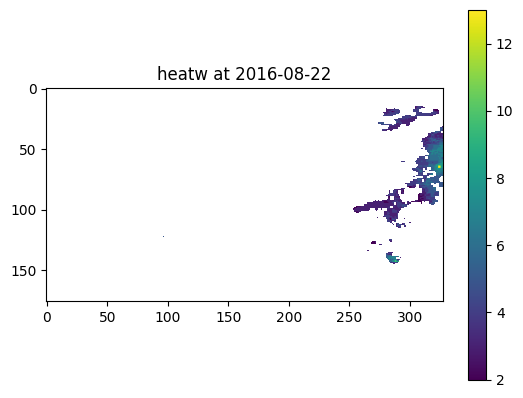

In [135]:
# Pick an arbitrary file to extract raster values from
slice = files_variables.sample(1, random_state=11)
rnd_file = slice["file"].values[0]
rnd_date = slice["date"].astype(str).values[0]

print(rnd_file)

# Load raster file and plot it
with rasterio.open(rnd_file) as src:
    raster = src.read(1)
    raster[raster == -9999] = np.nan

    # Get crs
    file_crs = src.crs.to_string()
    print(file_crs)
    plt.imshow(raster)
    plt.colorbar()
    plt.title(f"{subfolder} at {rnd_date}")
    plt.savefig(f"edo_qc_files/{subfolder}_raster_on_{rnd_date}.png")

# Load and Transform Coordinates


In [22]:
# Load latest coordinates for nfi sites
site_coordinates = pd.read_csv("../00_process_nfi_data/nfi_final_sites_with_idp.csv")

# Get subset of sites if desired
if subset_of_coors:
    site_coordinates = site_coordinates.sample(1000, random_state=42)

# Get a random set of sites to highlight
random_sites = site_coordinates.sample(9, random_state=42)["idp"]

# Turn into geodataframe and set crs to 3035
df_sites_org = site_coordinates.copy()[["idp", "first_year", "x_fr", "y_fr"]]
df_sites_org = gpd.GeoDataFrame(
    df_sites_org,
    geometry=gpd.points_from_xy(df_sites_org.x_fr, df_sites_org.y_fr),
    crs="EPSG:2154",
)

# Turn crs from 2154 to 3035
df_sites_filecrs = df_sites_org.to_crs(file_crs)

# From geodataframe, extract x and y locations
x_filecrs = df_sites_filecrs.geometry.x
y_filecrs = df_sites_filecrs.geometry.y

# Overwrite df_sites again and attach filecrs-based coordinates
df_sites = site_coordinates.copy()[["idp", "first_year"]]
df_sites["x"] = x_filecrs
df_sites["y"] = y_filecrs

# Attach start and end year for each site for easier extraction
df_sites["start_year"] = df_sites.first_year - 5
df_sites["end_year"] = df_sites.first_year + 5

# Print info
print(df_sites.shape)
df_sites.head(3)

(40022, 6)


idp  first_year         x          y  start_year  end_year
0  632691        2011 -2.842824  48.337505        2006      2016
1  702597        2012  3.349757  46.198025        2007      2017
2  706240        2012  3.361577  46.827747        2007      2017

In [39]:
# Create folium map to see if nfi_plots still fall within France
# Get subset to not plot all 40k sites, if not reduced already
if subset_of_coors:
    df_map1 = df_sites_org
    df_map2 = df_sites_filecrs
else:
    df_map1 = df_sites_org.sample(random_state=42, n=1000)
    df_map2 = df_sites_filecrs.sample(random_state=42, n=1000)

# Dataframe to highlight a specific site
df_highlight = df_sites_org.query("idp in @random_sites")

# Make map
m = folium.Map(location=[46.5, 2], zoom_start=6)

# Add original sites to map
folium.GeoJson(
    df_map1,
    name="Original NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="black"),
).add_to(m)

# Add transformed sites to map
folium.GeoJson(
    df_map2,
    name="Transformed NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="red", radius=1),
).add_to(m)

# Add highlighted sites to map
folium.GeoJson(
    df_highlight,
    name="Highlighted NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="blue", radius=5),
).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Save map
m.save(f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites.html")

# Show map
m

## Extract Data


### Load all years for all files into one dataframe


In [24]:
# Run in parallel
df_mp = run_mp(
    parallel_edo_extraction,
    df_list,
    progress_bar=True,
    num_cores=10,
    df_sites=df_sites,
    debug=False,
    expected_crs=file_crs,
)

100%|██████████| 10/10 [21:49<00:00, 130.96s/it]  


In [34]:
# Unlist results by concatenating them
df_unlisted = pd.concat(df_mp)

# Clean structure a bit
df_unlisted = df_unlisted.sort_values(["idp", "date"]).reset_index(drop=True)
df_unlisted.insert(0, "idp", df_unlisted.pop("idp"))
df_unlisted.insert(1, "date", df_unlisted.pop("date"))

# Set -9999 to NA
df_unlisted = df_unlisted.replace(-9999, np.nan)

# Attach season information
df_unlisted = match_season_to_month(df_unlisted)

# Attach information whether observation is from before or after first_year
# * Important Assumption: Measurement was done on 31st of August (fall-cut-off)
# Code looks ugly but works
df_unlisted["before_first_year"] = df_unlisted["date"] < (
    df_unlisted["first_year"].astype(str) + "-08-31"
).astype("datetime64[ns]")

# Display it
display(df_unlisted)

idp       date  heatw  first_year         x          y  \
0           500002 2005-01-01    NaN        2010  7.378014  48.253411   
18675033    562918 2005-01-01    NaN        2010  5.837938  47.805254   
18671016    562899 2005-01-01    NaN        2010 -1.980153  47.705838   
2068755     506900 2005-01-01    NaN        2010  1.574573  48.988112   
18666999    562896 2005-01-01    NaN        2010  0.788900  46.947840   
...            ...        ...    ...         ...       ...        ...   
151688025  1117717 2021-12-31    8.0        2016  6.376465  46.806061   
151692043  1117727 2021-12-31    NaN        2016  5.637757  44.380744   
151696061  1117750 2021-12-31    NaN        2016  0.607629  46.864264   
151704097  1117767 2021-12-31    NaN        2016 -0.884106  45.913565   
160796831  1131437 2021-12-31    NaN        2016  3.417427  46.998179   

           start_year  end_year  season  before_first_year  
0                2005      2015  winter               True  
18675033         2005      2015  winter               True  
18671016         2005      2015  winter               True  
2068755          2005      2015  winter               True  
18666999         2005      2015  winter               True  
...               ...       ...     ...                ...  
151688025        2011      2021  winter              False  
151692043        2011      2021  winter              False  
151696061        2011      2021  winter              False  
151704097        2011      2021  winter              False  
160796831        2011      2021  winter              False  

[160796832 rows x 10 columns]

In [ ]:
# Save pre-aggregation dataframe
if subset_of_coors:
    savedfeather = f"data_edo_{subfolder}_pre_aggregation_subset.feather"
else:
    savedfeather = f"data_edo_{subfolder}_pre_aggregation.feather"

df_unlisted.reset_index(drop=True).to_feather(savedfeather)

print(f"✅ Successfully saved dataframe: {savedfeather}")

✅ Successfully saved dataframe: data_edo_heatwpre_aggregation.feather


### Quality Control of Extraction


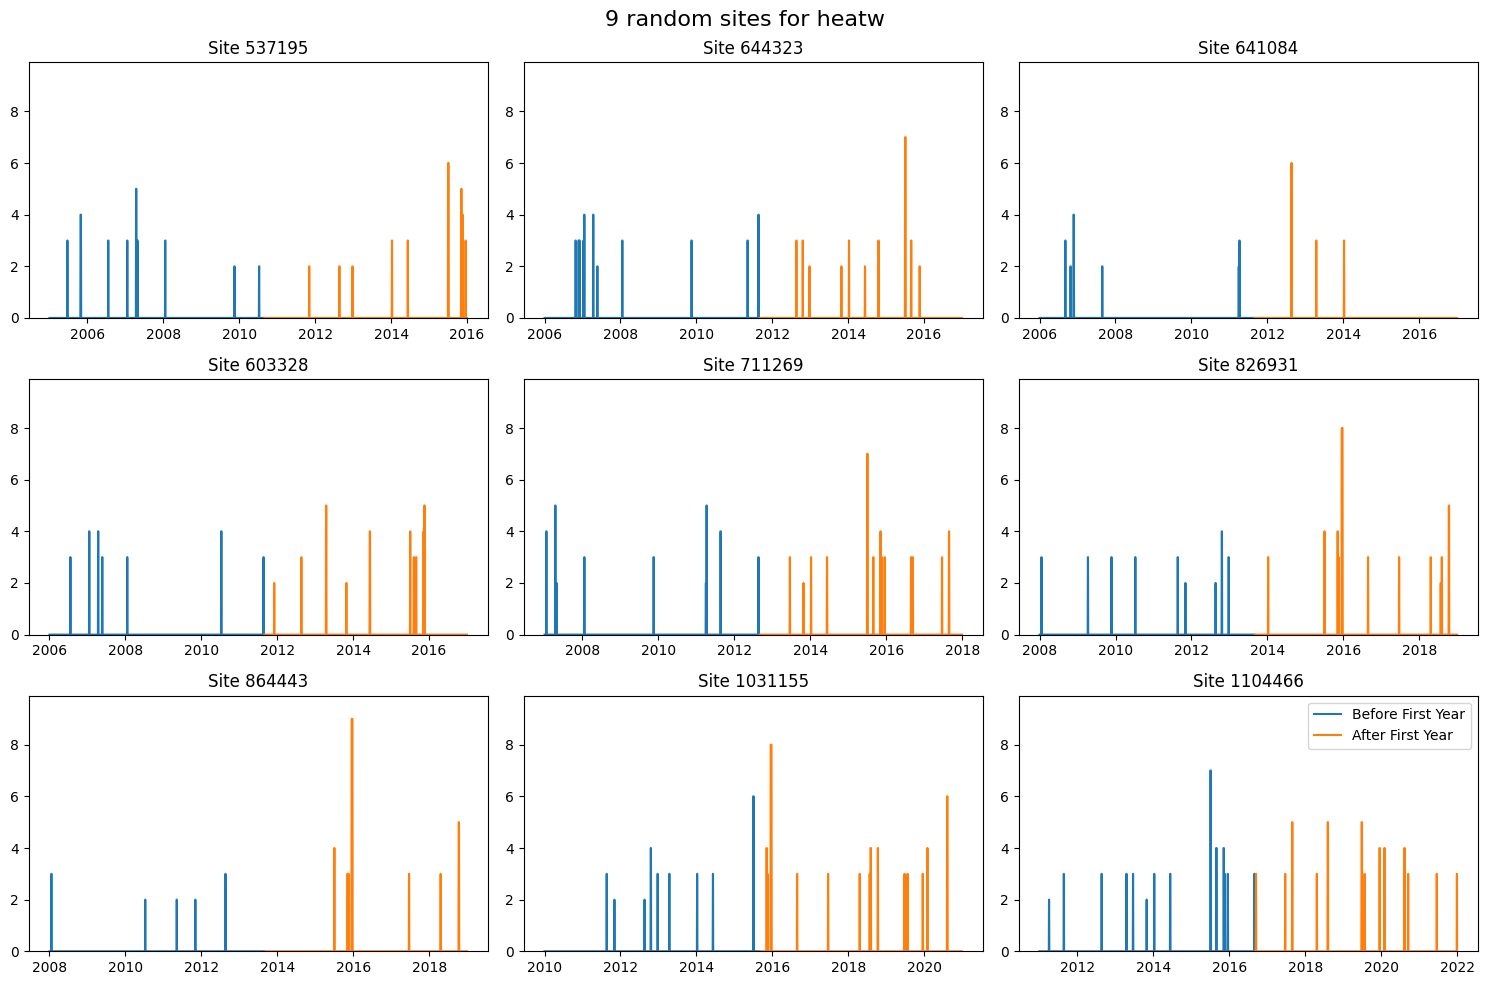

In [41]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Add a title to the entire grid
fig.suptitle(f"{len(axes.flatten())} random sites for {subfolder}", fontsize=16)

# Reduce df_unlisted to sites in random_sites
df_red = df_unlisted.query("idp in @random_sites").copy().reset_index(drop=True)

# If heatwave dataset, replace NA by 0 to make plot more readable
if subfolder == "heatw":
    df_red[subfolder] = df_red[subfolder].fillna(0)

# Get minimum and maximum value for y-axis
min_ = df_red[subfolder].min()
max_ = df_red[subfolder].max()

# Iterate over each subplot
for i, ax in enumerate(axes.flatten()):
    # Reduce df_unlisted to sites in random_sites
    random_site = df_red["idp"].unique()[i]

    # Get subset
    subset = df_red[df_red["idp"] == random_site]

    # Plot subset when before_first_year is true
    ax.plot(
        subset[subset["before_first_year"]]["date"],
        subset[subset["before_first_year"]][subfolder],
        label="Before First Year",
    )

    # Plot subset when before_first_year is false
    ax.plot(
        subset[~subset["before_first_year"]]["date"],
        subset[~subset["before_first_year"]][subfolder],
        label="After First Year",
    )

    ax.set_title(f"Site {random_site}")

    # Set y-axis limits
    ax.set_ylim((min_ + min_ * 0.1), (max_ + max_ * 0.1))

# Add legend to the last subplot
axes.flatten()[-1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"edo_qc_files/{subfolder}_random_sites.png")

# Show the plot
plt.show()

### Reduce Data to Seasonal Aggregates


In [46]:
# Separate into before and after first_year
df_before = df_unlisted[df_unlisted.before_first_year == True]
df_after = df_unlisted[df_unlisted.before_first_year == False]

# Aggregate per site and season
agg_functions = ["mean", "std", "range", "median", "iqr"]

# If heatwave, add count of heatwave days
if subfolder == "heatw":
    agg_functions.append("sum")

# Time between first_year and first_year + 5
df_after = df_after.drop(columns=["before_first_year"])

seasonal_aggregation_per_site(
    df_after.query("idp in @random_sites"),
    current_var=subfolder,
    fcts_to_apply=agg_functions,
)

100%|██████████| 9/9 [00:00<00:00, 137.93it/s]


idp  mean_of_heatw_in_summer  mean_of_heatw_in_fall  \
0   537195                 4.384615               2.000000   
0   603328                 3.473684               4.000000   
0   641084                 6.000000                    NaN   
0   644323                 4.470588               2.538461   
0   711269                 4.185185               3.076923   
0   826931                 3.058824               3.571429   
0   864443                 3.571429               3.000000   
0  1031155                 3.884615               3.727273   
0  1104466                 4.241379               3.000000   

   mean_of_heatw_in_winter  mean_of_heatw_in_spring  std_of_heatw_in_summer  \
0                 2.500000                      NaN                1.850156   
0                 2.000000                      5.0                0.512989   
0                 3.000000                      3.0                0.000000   
0                 2.500000                      NaN                2.211268   
0                 3.000000                      NaN                1.732873   
0                 6.846154                      3.0                0.658653   
0                 9.000000                      3.0                0.534522   
0                 6.000000                      3.0                1.243444   
0                 4.000000                      3.0                0.912421   

   std_of_heatw_in_fall  std_of_heatw_in_winter  std_of_heatw_in_spring  \
0              0.000000                0.547723                     NaN   
0              1.224745                0.000000                     0.0   
0                   NaN                0.000000                     0.0   
0              0.518875                0.547723                     NaN   
0              0.759555                0.000000                     NaN   
0              0.534522                2.192645                     0.0   
0              0.000000                0.000000                     0.0   
0              0.467099                2.326320                     0.0   
0              0.000000                0.000000                     0.0   

   range_of_heatw_in_summer  ...  median_of_heatw_in_winter  \
0                       4.0  ...                        2.5   
0                       1.0  ...                        2.0   
0                       0.0  ...                        3.0   
0                       5.0  ...                        2.5   
0                       4.0  ...                        3.0   
0                       2.0  ...                        8.0   
0                       1.0  ...                        9.0   
0                       3.0  ...                        8.0   
0                       2.0  ...                        4.0   

   median_of_heatw_in_spring  iqr_of_heatw_in_summer  iqr_of_heatw_in_fall  \
0                        NaN                     3.0                   0.0   
0                        5.0                     1.0                   1.0   
0                        3.0                     0.0                   NaN   
0                        NaN                     4.0                   1.0   
0                        NaN                     2.5                   1.0   
0                        3.0                     0.0                   1.0   
0                        3.0                     1.0                   0.0   
0                        3.0                     1.0                   0.5   
0                        3.0                     2.0                   0.0   

   iqr_of_heatw_in_winter  iqr_of_heatw_in_spring  sum_of_heatw_in_summer  \
0                     1.0                     NaN                    57.0   
0                     0.0                     0.0                    66.0   
0                     0.0                     0.0                    36.0   
0                     1.0                     NaN                    76.0   
0                     0.0                     N

In [56]:
df_after.query("idp == 1104466").groupby("season")[subfolder].agg(np.nansum)

season
fall       18.0
spring      9.0
summer    123.0
winter     41.0
Name: heatw, dtype: float32

In [70]:
df_after.query(
    "idp == 1104466 and season == 'summer' and date > '2011-08-31'"
).dropna().head(20)

idp       date  heatw  first_year         x          y  \
143160174  1104466 2017-06-20    3.0        2016  5.780498  47.743949   
143160175  1104466 2017-06-21    3.0        2016  5.780498  47.743949   
143160176  1104466 2017-06-22    3.0        2016  5.780498  47.743949   
143160241  1104466 2017-08-26    5.0        2016  5.780498  47.743949   
143160242  1104466 2017-08-27    5.0        2016  5.780498  47.743949   
143160243  1104466 2017-08-28    5.0        2016  5.780498  47.743949   
143160244  1104466 2017-08-29    5.0        2016  5.780498  47.743949   
143160245  1104466 2017-08-30    5.0        2016  5.780498  47.743949   
143160583  1104466 2018-08-03    5.0        2016  5.780498  47.743949   
143160584  1104466 2018-08-04    5.0        2016  5.780498  47.743949   
143160585  1104466 2018-08-05    5.0        2016  5.780498  47.743949   
143160586  1104466 2018-08-06    5.0        2016  5.780498  47.743949   
143160587  1104466 2018-08-07    5.0        2016  5.780498  47.743949   
143160909  1104466 2019-06-25    5.0        2016  5.780498  47.743949   
143160910  1104466 2019-06-26    5.0        2016  5.780498  47.743949   
143160911  1104466 2019-06-27    5.0        2016  5.780498  47.743949   
143160912  1104466 2019-06-28    5.0        2016  5.780498  47.743949   
143160913  1104466 2019-06-29    5.0        2016  5.780498  47.743949   
143160914  1104466 2019-06-30    5.0        2016  5.780498  47.743949   
143160938  1104466 2019-07-24    3.0        2016  5.780498  47.743949   

           start_year  end_year  season  
143160174        2011      2021  summer  
143160175        2011      2021  summer  
143160176        2011      2021  summer  
143160241        2011      2021  summer  
143160242        2011      2021  summer  
143160243        2011      2021  summer  
143160244        2011      2021  summer  
143160245        2011      2021  summer  
143160583        2011      2021  summer  
143160584        2011      2021  summer  
143160585        2011      2021  summer  
143160586        2011      2021  summer  
143160587        2011      2021  summer  
143160909        2011      2021  summer  
143160910        2011      2021  summer  
143160911        2011      2021  summer  
143160912        2011      2021  summer  
143160913        2011      2021  summer  
143160914        2011      2021  summer  
143160938        2011      2021  summer

In [42]:
# Separate into before and after first_year
df_before = df_unlisted[df_unlisted.before_first_year == True]
df_after = df_unlisted[df_unlisted.before_first_year == False]

# Aggregate per site and season
agg_functions = ["mean", "std", "range", "median", "iqr"]

# If heatwave, add count of heatwave days
if subfolder == "heatw":
    agg_functions.append("sum")

# Time between first_year and first_year + 5
df_after = df_after.drop(columns=["before_first_year"])
df_after = seasonal_aggregation_per_site(
    df_after, current_var=subfolder, fcts_to_apply=agg_functions
)

# Time between first_year - 5 and first_year
# Need to subtract 5 from first_year to match function format
df_before = df_before.drop(columns=["before_first_year"])
df_before["first_year"] = df_before["first_year"] - 5
df_before = seasonal_aggregation_per_site(
    df_before, current_var=subfolder, fcts_to_apply=agg_functions
)

  0%|          | 0/40022 [00:00<?, ?it/s]/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/pascal/repos/pada

KeyboardInterrupt: 

In [28]:
# Attach suffix _5yrafter to all variables in df_after except idp
df_after_sf = (
    df_after.add_suffix("_Tpls5")
    .rename(columns={"idp_Tpls5": "idp"})
    .reset_index(drop=True)
)
df_before_sf = (
    df_before.add_suffix("_tmin5")
    .rename(columns={"idp_tmin5": "idp"})
    .reset_index(drop=True)
)

# Merge variables into one dataframe
df_full = pd.merge(
    df_before_sf,
    df_after_sf,
    how="left",
    validate="one_to_one",
)

In [29]:
# Quick check
display(df_full)
if not df_full["idp"].nunique() == site_coordinates.idp.nunique():
    print("❌❌❌ Not all sites are included in the final dataframe ❌❌❌")
else:
    print("✅✅✅ All sites are included in the final dataframe ✅✅✅")

idp  mean_of_heatw_in_winter_tmin5  mean_of_heatw_in_spring_tmin5  \
0       500002                       3.000000                       4.000000   
1       500008                       3.142857                            NaN   
2       500012                       3.000000                       4.772727   
3       500013                       4.000000                       4.000000   
4       500042                       3.571429                       3.750000   
...        ...                            ...                            ...   
40017  1131409                       4.200000                       3.000000   
40018  1131410                            NaN                       5.000000   
40019  1131419                       5.846154                            NaN   
40020  1131424                       2.000000                            NaN   
40021  1131437                       3.750000                            NaN   

       mean_of_heatw_in_summer_tmin5  mean_of_heatw_in_fall_tmin5  \
0                           3.000000                     4.000000   
1                           3.000000                     4.000000   
2                           3.000000                     2.571429   
3                           3.000000                     3.000000   
4                           3.142857                     5.100000   
...                              ...                          ...   
40017                       2.500000                          NaN   
40018                       3.062500                     3.000000   
40019                            NaN                     2.666667   
40020                       4.666667                     3.250000   
40021                       4.125000                     3.461539   

       std_of_heatw_in_winter_tmin5  std_of_heatw_in_spring_tmin5  \
0                          0.000000                      0.000000   
1                          1.069045                           NaN   
2                          0.000000                      0.428932   
3                          0.000000                      0.000000   
4                          0.534522                      0.452267   
...                             ...                           ...   
40017                      1.032796                      0.000000   
40018                           NaN                      0.000000   
40019                      1.519109                           NaN   
40020                      0.000000                           NaN   
40021                      1.356801                           NaN   

       std_of_heatw_in_summer_tmin5  std_of_heatw_in_fall_tmin5  \
0                          0.000000                    0.000000   
1                          0.000000                    0.000000   
2                          0.000000                    0.534522   
3                          0.000000                    0.000000   
4                          1.069045                    1.449138   
...                             ...                         ...   
40017                      0.547723                         NaN   
40018                      0.680074                    0.000000   
40019                           NaN                    0.500000   
40020                      2.000000                    1.035098   
40021                      1.746425                    0.518875   

       range_of_heatw_in_winter_tmin5  ...  mean_of_heatw_in_winter_Tpls5  \
0                                 0.0  ...                       2.000000   
1                                 2.0  ...                       3.000000   
2                                 0.0  ...                       3.000000   
3                                 0.0  ...                            NaN   
4                                 1.0  ...                       3.000000   
...                               ...  ...                            ...   
40017                             2.0  ...      

✅✅✅ All sites are included in the final dataframe ✅✅✅


## Save Data


In [30]:
# Save dataframe
if subset_of_coors:
    savedcsv = f"data_edo_{subfolder}_subset.csv"
    savedfeather = f"data_edo_{subfolder}_subset.feather"
else:
    savedcsv = f"data_edo_{subfolder}.csv"
    savedfeather = f"data_edo_{subfolder}.feather"

df_full.to_csv(savedcsv, index=False)
df_full.to_feather(savedfeather)

print(f"✅ Successfully saved dataframe: {savedcsv} | {savedfeather}")
chime.success()

✅ Successfully saved dataframe: data_edo_heatw.csv | data_edo_heatw.feather
